# Aprendizaje temporal diferencial

El aprendizaje temporal diferencial (TD) es una combinación de ideas de DP y MCM. Los métodos TD pueden aprender directamente de la experencia obtenida a través de la interacción con el entorno sin necesidad de tener un modelo del mismo (como MCM), además se actualizan los valores estimados a partir de otros valores estimados sin necesidad de esperar al final de un episodio (como DP, *bootstrap*).

## Predicción

Como MCM, TD usa experencia para resolver el problema de la predicción. Dada una experiencia siguiendo la política $\pi$, se actualizan los valores estimados de $v_\pi$, $V$, para los estados no terminales $S_t$ presentes en la experiencia. A grandes rasgos, MCM esperan a tener el retorno para hacer esta actualización

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)]
\end{equation}

donde $G_t$ es el retorno a partir de $t$ y $\alpha$ es el ratio de aprendizaje. A este método se le conoce como *contant-\alpha MC$. A diferencia de MCM, TD no necesitan esperar a obtener el retorno, si no que hacen esta actualización de manera inmediata

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha [R_t + \gamma V(S_{t+1}) - V(S_t)]
\end{equation}

Este método se conoce como $TD(0)$, o *one-step TD* (caso especial de $TD(\lambda)$ y *n-step TD*.

TD presenta las siguientes ventajas con respecto a DP y MCM:

- No necesitan un modelo del entorno.
- Implementación on-line e incremental (no necesitamos esperar al final de un episodio para axtualizar valores estimados).
- Suelen converger más rápido

Vamos a comparar TD y MCM en el siguiente proceso de recompensa de Markov (como un MDP, pero sin acciones).

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/MRP.JPG)

Todos los episodios empiezan en el estado central, $C$, desde donde un agente puede moverse a derecha o izquierda con igual probabilidad. Un episodio termina cuando cualquiera de los estados terminales son alcanzados, con una recompensa de +1 si termina en el extremo derecho y de 0 en el izquierdo. Con un factor de descuento de 1, el valor real de cada estado es la probabilidad de llegar al extremo derecho desde ese estado.

In [1]:
s = ["A", "B", "C", "D", "E"]
v = [1/6, 2/6, 3/6, 4/6, 5/6]

In [2]:
import numpy as np

def TD(episodes, alpha=0.1, gamma=1):
    V = np.ones(7)*0.5 
    V[0], V[6] = 0, 0
    history = []
    for e in range(1, episodes+1):
        S = 3 # empezamos en C
        # generate episode: S0, A0, R1, S1, A1, R2, ...
        episode = []
        fin = False
        while not fin:        
            # acción
            a = np.random.randn()
            R = 0
            # derecha
            if a > 0:
                if S == 5:
                    # extremo derecho
                    R = 1
                    fin = True
                Sp = S + 1
            # izquierda
            else:
                # extremo izquierdo
                if S == 1:
                    fin = True
                Sp = S - 1
            V[S] += alpha*(R + gamma*V[Sp] - V[S])
            S = Sp
        history.append(V.copy())
    return np.array(history)

In [3]:
V1 = TD(1)
V10 = TD(10)
V100 = TD(100)

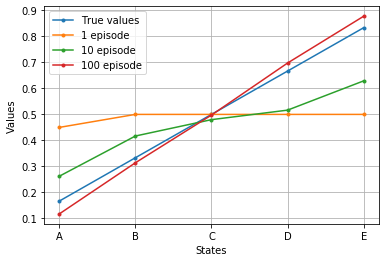

In [4]:
import matplotlib.pyplot as plt

plt.plot(s, v, '.-', label="True values")
plt.plot(s, V1[-1,1:-1], '.-', label="1 episode")
plt.plot(s, V10[-1,1:-1], '.-', label="10 episode")
plt.plot(s, V100[-1,1:-1], '.-', label="100 episode")
plt.grid(True)
plt.legend()
plt.xlabel("States")
plt.ylabel("Values")
plt.show()

In [32]:
def MCM(episodes, alpha=0.02, gamma=1, no_estacionario=True):
    # estimated values
    V = np.ones(7)*0.5 
    V[0], V[6] = 0, 0
    # returns
    returns = [[] for i in range(7)]
    history = []
    for e in range(1, episodes+1):
        # generate episode: S0, A0, R1, S1, A1, R2, ...
        episode = []
        S = 3 # empezamos en C
        fin = False
        while not fin:        
            # acción
            a = np.random.randn()
            R = 0
            # derecha
            if a > 0:
                if S == 5:
                    # extremo derecho
                    R = 1
                    fin = True
                Sp = S + 1
            # izquierda
            else:
                # extremo izquierdo
                if S == 1:
                    fin = True
                Sp = S - 1
            # guardar step    
            episode.append((S, a, R))
            S = Sp
        # update returns
        G = 0
        for S, A, R in reversed(episode):
            G = gamma*G + R
            # every visit                       
            if no_estacionario:
                V[S] += alpha*(G - V[S])
            else:
                # algoritmo original
                returns[S].append(G)
                V[S] = np.mean(returns[S])
        history.append(V.copy())
    return np.array(history)

In [33]:
V1 = MCM(1)
V10 = MCM(10)
V100 = MCM(100)

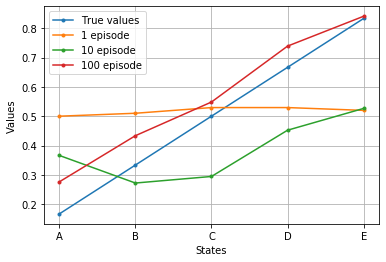

In [34]:
plt.plot(s, v, '.-', label="True values")
plt.plot(s, V1[-1,1:-1], '.-', label="1 episode")
plt.plot(s, V10[-1,1:-1], '.-', label="10 episode")
plt.plot(s, V100[-1,1:-1], '.-', label="100 episode")
plt.grid(True)
plt.legend()
plt.xlabel("States")
plt.ylabel("Values")
plt.show()

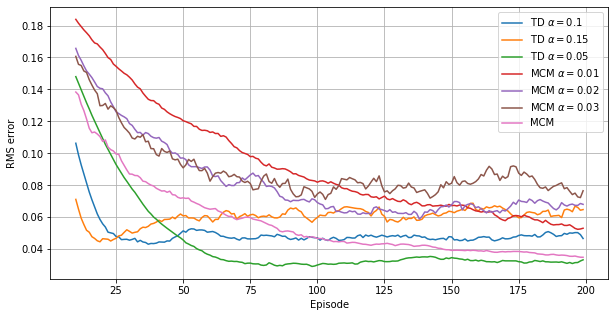

In [44]:
runs = 100
episodes = 200 
results = np.empty((runs, episodes, 5))
plt.figure(figsize=(10,5))
for alpha in (0.1, 0.15, 0.05):
    for run in range(runs):
        results[run,:,:] = np.sqrt(np.power(TD(episodes, alpha)[:,1:-1] - v, 2))
    plt.plot(range(10, episodes), results.mean(axis=0).mean(axis=1)[10:], label=fr'TD $\alpha={alpha}$')
for alpha in (0.01, 0.02, 0.03):
    for run in range(runs):
        results[run,:,:] = np.sqrt(np.power(MCM(episodes, alpha)[:,1:-1] - v, 2))
    plt.plot(range(10, episodes), results.mean(axis=0).mean(axis=1)[10:], label=fr'MCM $\alpha={alpha}$')
for run in range(runs):
    results[run,:,:] = np.sqrt(np.power(MCM(episodes, no_estacionario=False)[:,1:-1] - v, 2))
plt.plot(range(10, episodes), results.mean(axis=0).mean(axis=1)[10:], label='MCM')
plt.grid(True)
plt.xlabel("Episode")
plt.ylabel("RMS error")
plt.legend()
plt.show()

TD converge más rápido, y necesita menos memoria.

## Control

Siguiendo con el patrón de *generalized policy iteration* (GPI) nos encontramos con la necesidad de explorar y explotar el entorno, y podemos hacerlo de manera *on-policy* o *off-policy*. Vamos a ver un método de cada aplicado al siguiente caso.



![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/rl_markov.JPG)



In [45]:
probas_transiciones = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # p(s'| s0, a0), p(s'| s0, a1), p(s'| s0, a2)
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]           ], # p(s'| s1, a0), p(s'| s1, a1), p(s'| s1, a2)
    [None,            [0.8, 0.1, 0.1], None           ]  # p(s'| s2, a0), p(s'| s2, a1), p(s'| s2, a2)
]

recompensas = [ 
    [[+10, 0, 0], [0, 0, 0],   [0, 0, 0]],   # r(s', s0, a0), r(s', s0, a1), r(s', s0, a2)
    [[0, 0, 0],   [0, 0, 0],   [0, 0, -50]], # r(s', s1, a0), r(s', s1, a1), r(s', s1, a2)
    [[0, 0, 0],   [+40, 0, 0], [0, 0, 0]]    # r(s', s2, a0), r(s', s2, a1), r(s', s2, a2)
]

acciones = [
    [0, 1, 2], 
    [0, 2], 
    [1]
]

### Sarsa: *On-policy*

Podemos estimar la función de acción-valor $q_\pi(s,a)$ con la siguiente expresion

\begin{equation}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
\end{equation}

Esta actualización se lleva a cabo después de cada transición desde un estado no terminal (en el caso terminal $Q(S_{t+1}, A_{t+1}) = 0$). Este algoritmo se llama *Sarsa* ya que para aplicarlo necesitamos información de $S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}$. Como en cualquier método *on-policy* estimaremos $q_\pi$ usando el comportamiento definido por $\pi$, y a la vez iremos cambiando $\pi$ de manera *greedy* respecto de $q_\pi$.

In [136]:
# política aleatoria
def pi(s, Q, acciones, epsilon=0.3):
    return np.random.choice(acciones[s])

# entorno
def env(s, a):
    p = probas_transiciones[s][a]
    sp = np.random.choice([0, 1, 2], p=p)
    r = recompensas[s][a][sp]
    return r, sp

# inicializamos Q
Q = np.full((3, 3), -np.inf)
for s, a in enumerate(acciones):
    Q[s, a] = 0

s = 0 # estado inicial
alpha = 0.05
gamma = 0.9
for episodio in range(10000):
    a = pi(s, Q, acciones)
    r, sp = env(s, a)
    ap = pi(sp, Q, acciones)
    Q[s, a] += alpha*(r + gamma*Q[sp, ap] - Q[s, a])
    s = sp

Q

array([[ -3.65984203,  -2.42917447,  -6.13265425],
       [-17.23915128,         -inf, -20.43697226],
       [        -inf,  34.00538925,         -inf]])

In [137]:
# política óptima

np.argmax(Q_values, axis=1) 

array([0, 0, 1], dtype=int64)

## Q-learning: *Off-policy*

En este caso la función de valor $Q$ aproxima $q_*$ independientemente de la política seguida.

\begin{equation}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]
\end{equation}


In [150]:
#inicializamos Q
Q = np.full((3, 3), -np.inf)
for s, a in enumerate(acciones):
    Q[s, a] = 0

s = 0 # estado inicial
alpha = 0.05
gamma = 0.9
for episodio in range(10000):
    a = pi(s, Q, acciones)
    r, sp = env(s, a)
    Q[s, a] += alpha*(r + gamma*np.max(Q[sp]) - Q[s, a])
    s = sp

Q

array([[25.51139879, 23.1951307 , 18.21543508],
       [ 0.08538939,        -inf, -4.44801398],
       [       -inf, 50.66897022,        -inf]])

In [151]:
# política óptima

np.argmax(Q_values, axis=1) 

array([0, 0, 1], dtype=int64)

## Resumen

Lo métodos TD son una altrenativa a MCM que nos permite aproximar una función de valor sin tener que esperar a tener el rotorno (fin de un episodio). Son computacionalmente más eficientes y convergen más rápido. Pueden usarse para encontrar la política óptima siguiendo *GPI*, donde la plítica y la función de valor van cambiando una con respecto de la otra aproximandose hacia sus valores óptimos. Cuando este proceso está basando en la experiencia, necesitamos mantener un cierto nivel de exploración. Esto puede llevarse a cabo mediante técnicas *on-policy* (Sarsa) o *off-policy* (Q-learning).

Estos métodos son los más usados hoy en día en axr debido a su simplicidad y efectividad. Pueden aplicarse de manera online, con unos requisitos computacionales bajos y aprenden a partir de la experiencia generada por la interacción del agente con su entorno. 

Los métodos presentados aquí son *one-step*, *tabular*, *model-free* TD. Se pueden generalizar a *n-steps* (siendo MC el caso límite donde usamos todos los steps de un episodio), pueden incluir modelo del entorno (similar a DP) o pueden usar funciones de aproximación en vez de tablas (usando, por ejemplo, redes neuronales). 